## author: Virginia Ordoño Bernier
## date: december 2023


## Prácticas Naive Bayes y KNN (ejercicio 1)

#### **1. Tomando como base este [tutorial](https://colab.research.google.com/drive/1zFIOfrceEaFkhQOEOkMWroBmNV1HAMVS?usp=drive_link),  crea un modelo de clasificación usando KNN con los mismos datos sintéticos. Para la elección de los mejores hiperparámetros usa un sistema de [validación cruzada](https://educacionadistancia.juntadeandalucia.es/centros/cordoba/pluginfile.php/406946/mod_resource/content/1/M2_SAA_S10%20-%20Validaci%C3%B3n.pdf).**

#### 2. Usando los datos almacenados en data2.csv, crea un modelo de clasificación usando los modelos de NaiveBayes mostrados en el [vídeo 5](https://vimeo.com/600140324). Indicad qué modelo da mejores resultados. Os toca investigar cómo cargar un archivo csv desde Google Collab.

#### 3. En este [enlace](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) puedes descargar un dataset que recoge diferentes características de vino rojo portugués "Vinho Verde" y la calidad del mismo. Crea un modelo de clasificación usando NaiveBayes (GaussianNB) y KNN.

#### 4. Plantea el problema anterior con un modelo de regresión usando KNN. En el [vídeo 7](https://vimeo.com/600141357) hay un ejemplo de regresión con KNN.

#### 1. Generación de datos sintéticos


In [102]:
import numpy as np

np.random.seed(41)

# Clase 0. Distribución normal de media 0 y desviación estándar 1
class_0_data = np.random.normal(0, 1, size=(100, 2))
class_0_labels = np.zeros(100) # Representación de etiquetas como ceros

# Clase 1. Distribución normal de media 3 y desviación estándar 1
class_1_data = np.random.normal(3, 1, size=(100, 2))
class_1_labels = np.ones(100) # Representación de etiquetas como unos

#### 2. Carga de datos

In [103]:
# Formateo de datos
X = np.vstack((class_0_data, class_1_data)) # Une dos matrices en una en forma de pila
y = np.concatenate((class_0_labels, class_1_labels)) # Concatena las matrices de los nombres en una en forma de columna

# Carga el Dataframe
import pandas as pd

# Crear DataFrames para las características y etiquetas
df_X = pd.DataFrame(X, columns=['Class_0', 'Class_1']) 
df_y = pd.DataFrame(y, columns=['Target'])

# Concatenar DataFrames
df_classes = pd.concat([df_X, df_y], axis=1)

# Clase target solo con enteros
df_classes.Target = df_classes.Target.astype(int)

df_classes

,Class_0,Class_1,Target
0,-0.270712,0.104848,0
1,0.250528,-0.925200,0
2,0.567144,-1.040180,0
3,-0.153676,0.789852,0
4,-1.226216,-0.948007,0
...,...,...,...
195,3.754550,4.091037,1
196,3.957150,3.399005,1
197,1.118678,2.318888,1
198,4.010052,3.822308,1


In [104]:
# Comprobamos valores de la columna Label
df_classes['Target'].unique()

array([0, 1])

#### 3. Selección de variables
Para realizar esta selección vamos a utilizar la correlación entre cada una de las características y la variable a predecir.


,Class_0,Class_1,Target
Class_0,1.000000,0.711657,0.810961
Class_1,0.711657,1.000000,0.861755
Target,0.810961,0.861755,1.000000


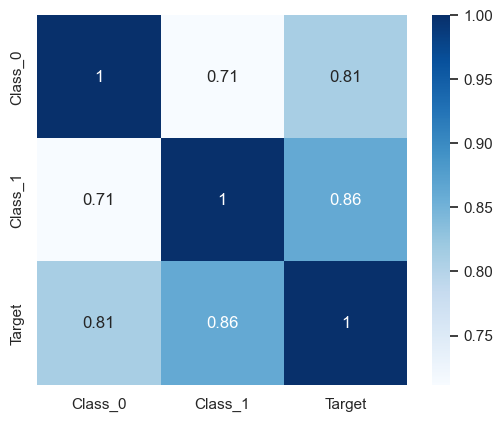

In [105]:
import seaborn as sns

sns.set()
sns.heatmap(df_classes.corr(), square=True, annot=True, cmap='Blues')

# Las variables con una correlación cercana a 1 tienen una correlación positiva fuerte, 
# Las variables con una correlación cercana a -1 tienen una correlación negativa fuerte. 
# Si la correlación está cerca de 0, las variables están débilmente correlacionadas.

df_classes.corr()

#### 4. Parametrización KNN y Validación Cruzada


In [106]:
from sklearn.model_selection import train_test_split

# División el conjunto de datos en train y test en un porcentaje de 2/3 vs 1/3
train, test = train_test_split(df_classes[['Class_0','Class_1', 'Target']], test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)

Máximo valor de precisión para pesos "uniform": 1.0 (Número de vecinos: 1)
Máximo valor de precisión para pesos "distance": 1.0 (Número de vecinos: 1)


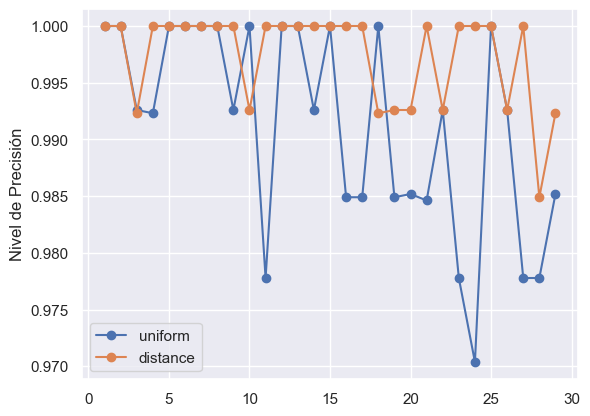

In [107]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluación del rendimiento de un clasificador K-Nearest Neighbors (KNN) con diferentes parámetros.

cv = KFold(n_splits = 5, shuffle = True) # 5 iteraciones de entremiento y evaluación (5 folds). 

# En cada iteración, se dividirán los datos en conjuntos de entrenamiento y prueba.
for i, weights in enumerate(['uniform', 'distance']): # Dos configuraciones: vecinos con mismo peso y pesos inversamente proporcionales a distancia
    
    total_scores = [] # Lista para almacenar los resultados de cada iteración
    
    for n_neighbors in range(1,30):
        fold_accuracy = [] # Lista para almacenar la precisión de cada fold
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        
        for train_fold, test_fold in cv.split(train): # Bucle para la CV
            
            # División de datos según índices obtenidos en la CV
            f_train = train.loc[train_fold]
            f_test = train.loc[test_fold]
            
            # Entrenamiento del modelo
            knn.fit( X = f_train.drop(['Target'], axis=1),
                            y = f_train['Target'])
            
            # Predicción de los datos de prueba
            y_pred = knn.predict(X = f_test.drop(['Target'], axis = 1))
            
            # Evaluación del modelo
            acc = accuracy_score(f_test['Target'], y_pred)
            
            # Almacenamiento de la precisión de cada fold
            fold_accuracy.append(acc)

        # Almacenamiento del cálculo del Promedio de Precisión por Vecino:    
        total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
        
    plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
    
    #print ('Máximo valor de precisión para pesos ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
    print(f'Máximo valor de precisión para pesos "{weights}": {max(total_scores)} (Número de vecinos: {np.argmax(total_scores) + 1})')
    plt.ylabel('Nivel de Precisión')

plt.legend()
plt.show()

#### 5a. Clasificador K-Nearest Neighbors (KNN) con Distance

In [108]:
# En las predicciones, los vecinos más cercanos tendrán un peso inversamente proporcional a su distancia.

# Configuración de hiperparámetros
n_neighbors = 29
weights = 'distance'

# Configuración del clasificador KNN
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)

# Entrenamiento del clasificador KNN
knn.fit(X = train[['Class_0','Class_1']], y = train['Target'])

# Predicción de los datos de test
y_pred = knn.predict(X = test[['Class_0','Class_1']])

# Evaluación del modelo
acc = accuracy_score(test['Target'], y_pred)
print(f'La precisión del modelo KNN con {n_neighbors} vecinos y pesos "{weights}" es: {acc:.4f}')


La precisión del modelo KNN con 29 vecinos y pesos "distance" es: 0.9394


#### 5b. Clasificador K-Nearest Neighbors (KNN) con Uniform

In [109]:
# En las predicciones, todos los vecinos más cercanos contribuirán por igual

# Configuración de hiperparámetros
n_neighbors_uniform = 29
weights_uniform = 'uniform'

# Creación del clasificador KNN con pesos uniformes
knn_uniform = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_uniform, weights=weights_uniform)

# Entrenamiento del modelo con pesos uniformes
knn_uniform.fit(X=train[['Class_0', 'Class_1']], y=train['Target'])

# Realización de predicciones en el conjunto de prueba
y_pred_uniform = knn_uniform.predict(X=test[['Class_0', 'Class_1']])

# Evaluación del rendimiento del modelo utilizando la métrica de precisión
accuracy_uniform = accuracy_score(test['Target'], y_pred_uniform)

# Impresión de la precisión obtenida en el conjunto de prueba con pesos uniformes
print(f'La precisión del modelo KNN con {n_neighbors_uniform} vecinos y pesos "{weights_uniform}" es: {accuracy_uniform:.4f}')


La precisión del modelo KNN con 29 vecinos y pesos "uniform" es: 0.9394


### 6. Visualización

#### 6.1. Matriz de Confusión

In [110]:
# Matriz de confusión

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
    # ... and label them with the respective list entries 
    xticklabels=classes, yticklabels=classes,
    title=title,
    ylabel='True label',
    xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[32  4]
 [ 0 30]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

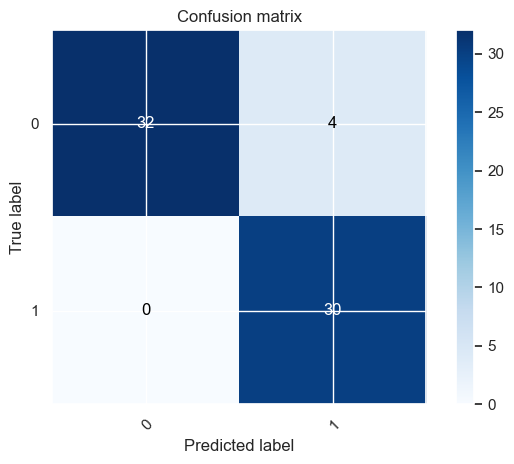

In [111]:
classes = df_classes['Target'].unique()
plot_confusion_matrix(test['Target'], y_pred, classes=classes, normalize=False, title='Confusion matrix')

#### 6.2. Voronoi

c:\Users\Virginia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


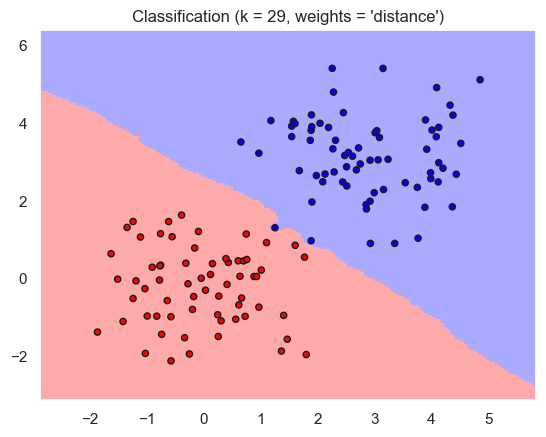

In [112]:
# Graficamos la solución mediante los diagramas de Voronoi

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .05  # step size in the mesh


X = train[['Class_0', 'Class_1']].to_numpy()
y = train['Target'].to_numpy()

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.show()